In [1]:
import mo_descriptor as md
import nn_frame as nn
import numpy as np
import subprocess
subprocess.run('export TF_INTRA_OP_PARALLELISM_THREADS=12', shell=True)

2022-07-13 15:51:20.461194: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-13 15:51:20.461237: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


CompletedProcess(args='export TF_INTRA_OP_PARALLELISM_THREADS=12', returncode=0)

In [2]:
'''
prepare data_set
1. make mo_pair descriptor
'''
# x_shift = np.arange(0, 4.1, 0.1)
# y_shift = np.arange(0, 4.1, 0.1)
# z_shift = np.zeros(x_shift.shape)
# # the original mo, e.g. homo
# homo = md.MO_descriptor('data/homo-s0.cube').make()
# lumo = md.MO_descriptor('data/lumo-s0.cube').make()

# # for the original pair of one mo and itself
# homo_pair = md.MO_pair_descriptor(homo, homo).make()
# lumo_pair = md.MO_pair_descriptor(lumo, lumo).make()

# # for the shifted pair
# homo_pairs = np.zeros((len(x_shift)*len(y_shift),) + homo_pair.shape)
# lumo_pairs = np.zeros((len(x_shift)*len(y_shift),) + lumo_pair.shape)
# for ii, i in enumerate(x_shift):
#     for jj, j in enumerate(y_shift):
#         idx = ii * len(y_shift) + jj
#         homo_pairs[idx][0] = homo_pair[0]
#         homo_pairs[idx][1] = np.add(homo_pair[1],i)
#         homo_pairs[idx][2] = np.add(homo_pair[2],j)
#         homo_pairs[idx][3] = homo_pair[3]
#         lumo_pairs[idx][0] = lumo_pair[0]
#         lumo_pairs[idx][1] = np.add(lumo_pair[1],i)
#         lumo_pairs[idx][2] = np.add(lumo_pair[2],j)
#         lumo_pairs[idx][3] = lumo_pair[3]
# np.save('homo_homo_pair.npy', homo_pairs)
# np.save('lumo_lumo_pair.npy', lumo_pairs)
homo_pairs = np.load('homo_homo_pair.npy')
lumo_pairs = np.load('lumo_lumo_pair.npy')

In [3]:
'''
2. read coupling
'''
raw_data = np.loadtxt('data/cdft-V1V2.dat')
c_homo = np.add(raw_data[:,2], raw_data[:,3]) * 1/2
c_lumo = np.add(raw_data[:,4], raw_data[:,5]) * 1/2

In [4]:
train_homo_pairs = homo_pairs
train_lumo_pairs = lumo_pairs[0:1200]

train_c_homo = c_homo
train_c_lumo = c_lumo[0:1200]

test_homo_pairs = homo_pairs[1200:]
test_lumo_pairs = lumo_pairs[1200:]

test_c_homo = c_homo[1200:].reshape((len(c_homo[1200:]),1))
test_c_lumo = c_lumo[1200:]

In [13]:
setting = {'activation':'tanh', 'nn_shape':(240,240,240), 'batch_size':1800, 'training_steps':1000000,\
'learning_rate': 0.001, 'decay_rate':0.95, 'decay_per_steps':1000, 'save_step':10000}
NN = nn.NN(setting_dict=setting)
NN.train(train_homo_pairs,train_c_homo)
# NN.test(test_homo_pairs, test_c_homo)

training step:     0, loss:  0.904251635
training step: 10000, loss:  0.320497334
training step: 20000, loss:  0.076791346
training step: 30000, loss:  0.056783039
training step: 40000, loss:  0.037199732
training step: 50000, loss:  0.024030311
training step: 60000, loss:  0.015260174
training step: 70000, loss:  0.009632736
training step: 80000, loss:  0.006876539
training step: 90000, loss:  0.005360496
training step: 100000, loss:  0.004423627
training step: 110000, loss:  0.003752836
training step: 120000, loss:  0.003324962
training step: 130000, loss:  0.003058505
training step: 140000, loss:  0.002869328
training step: 150000, loss:  0.002728049
training step: 160000, loss:  0.002615484
training step: 170000, loss:  0.002540821
training step: 180000, loss:  0.002486232
training step: 190000, loss:  0.002458658
training step: 200000, loss:  0.002441828
training step: 210000, loss:  0.002430415
training step: 220000, loss:  0.002422545
training step: 230000, loss:  0.002417470
tr

KeyboardInterrupt: 

In [15]:
print((NN.model(test_homo_pairs)-test_c_homo)/test_c_homo)
print(np.mean((NN.model(test_homo_pairs)-test_c_homo)/test_c_homo))

tf.Tensor(
[[-1.00290097e-01]
 [-1.31290764e-01]
 [-1.50280699e-01]
 [-5.02567440e-02]
 [ 1.72641784e-01]
 [ 6.74266338e-01]
 [ 2.46938753e+00]
 [ 1.48710365e+01]
 [ 1.40424907e+00]
 [ 4.49716449e-01]
 [ 2.31115311e-01]
 [ 1.89665243e-01]
 [ 1.32600382e-01]
 [ 6.56345710e-02]
 [ 1.36721591e-02]
 [-2.32519712e-02]
 [-4.84452061e-02]
 [-6.42860532e-02]
 [-7.21702501e-02]
 [-7.35542625e-02]
 [-6.92966431e-02]
 [-6.00720681e-02]
 [-4.69268970e-02]
 [-3.14099118e-02]
 [-1.55854113e-02]
 [-1.83970388e-03]
 [ 7.95463007e-03]
 [ 1.39110181e-02]
 [ 1.86709370e-02]
 [ 2.68938746e-02]
 [-5.17163128e-02]
 [-3.73472944e-02]
 [-2.24142112e-02]
 [-1.39126349e-02]
 [-2.03458034e-02]
 [-3.87156010e-02]
 [-5.10482453e-02]
 [-5.00630885e-02]
 [-4.95770983e-02]
 [-6.81881234e-02]
 [-1.10235065e-01]
 [-1.59338772e-01]
 [-1.98298380e-01]
 [-2.04402551e-01]
 [-5.86616173e-02]
 [ 2.36799449e-01]
 [ 8.99701357e-01]
 [ 3.44066215e+00]
 [ 1.07924471e+01]
 [ 1.61311364e+00]
 [ 6.21914089e-01]
 [ 3.43916118e-01]
 

(31, 31)


Text(0.5, 1.0, 'true')

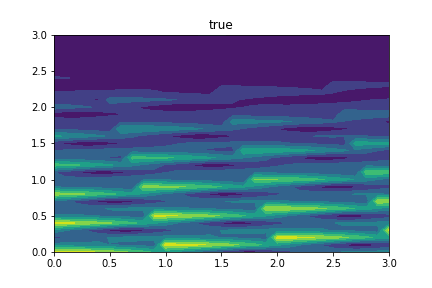

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

x = np.linspace(0, 3, 31)
y = np.linspace(0, 3, 31)
X, Y = np.meshgrid(x, y)
Z = NN.model(train_homo_pairs).numpy()[0:961].reshape((31,31))
Z1 = c_homo[0:961].reshape((31,31))
print(Z.shape)

fix, ax = plt.subplots()
ax.contourf(x,y, Z1)
ax.set_title('true')

Text(0.5, 1.0, 'pred')

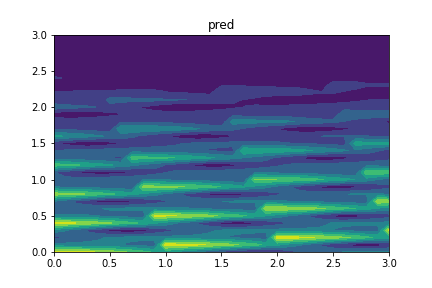

In [47]:
fix, ax = plt.subplots()
ax.contourf(x,y, Z)
ax.set_title('pred')